# Tensorboard con Pytorch

Tensorboard es una herramientas de visualización asociada al ecosistema de TensorFlow. Es tan popular, que también está soportada en Pytorch y su uso es habitual. Permite visualizar:

- Métricas como la *loss* o la *accuracy*.
- El grafo que representa la arquitectura del modelo
- La evolución en tiempo real de los histogramas de pesos y *bias*
- Información de rendmimiento computacional: uso de GPU, línea de tiempo de la ejecución, uso de memoria, etc...

Vamos a ver un ejemplo en el que usamos una red convolucional sencilla para realizar una operación de clasificación sobre el conjunto de datos MNIST. En este conjunto de datos, tenemos que identificar en una imagen el tipo de prenda que muestran. Empezamos cargando el conjunto de datos utilizando el módulo torchvision.



In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

100%|██████████| 26421880/26421880 [00:06<00:00, 4090682.40it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 552485.54it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 9029693.27it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14728701.90it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



A continuación, realizamos la definición de la red convolucional que vamos a entrenar y la instanciamos. La red está compuesta por los siguientes elementos:
- Las imágenes de este data set tienen un único canal (b/n) y un tamaño de 28x28 píxeles.
- Una capa Convolucional.
- Una capa MaxPool2d.
- y Tres capas lineales totalmente conectadas. Terminando en una salida compuest por 10 probabilidades, cada una asociada a un tipo de prenda.

Luego, definimos la función de pérdida (*Cross-Entropy-Loss) y el optimizador (SGD).

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Ahora, vamos a empezar con la configuración de TensorBoard, creando un *SummaryWriter* que lleva asociada una ubicación en el sistema de ficheros, donde vamos a escribir los datos necesarias para luego utilizar TensorBoard.

In [4]:
!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

Defaulting to user installation because normal site-packages is not writeable


Vamos a ver, en primer lugar, cómo escribir una rejilla *grid* de imágenes aleatorias de nuestro conjunto de datos, para poder visualizarlas desde TensorBoard

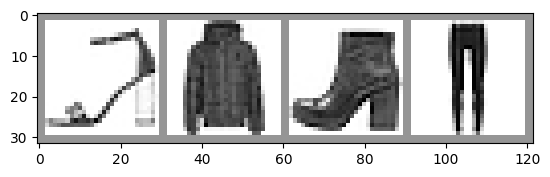

In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)



Dependiendo de cómo estemos usando este notebook, vamos a tener distintas formas de utilizar TensorBoard. Una que debería funciona en prácticamente cualquier entorno, es en un terminar ejecutar el siguiente comando.

tensorboard --logdir=runs

Otra cosa que podemos hacer con TensorBoard es visualizar la arquitectura del modelo. Para ello, debemos ejecutar el siguiente código


In [8]:
writer.add_graph(net, images)
writer.close()

Otra herramienta de visualización que resulta muy útil son los *Projectors*. Estos generan una representación de baja dimensionalidad de datos de alta dimensionalidad. Para ello, utilizaremos el método *add_embedding*. Veamos un ejemplo.

In [10]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

En TensorBoard, deberíamos tener una pestaña más que contiene la información generada por el Proyector.

A continuación, vamos a ver otro ejemplo, en este caso de cómo generar información sobre la evolución de la función de pérdida (*loss*), y además de una vista de las predicciones que está generando el modelo *plot_classes_pred*. Para ello, tenemos que definir un par de funciones.


In [11]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Para hacer uso de la función anterior, *plot_classes_pred* tenemos que utilizarla en el contexto de un bucle de entrenamiento. Veamos cómo se integra.

In [12]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


Si abrimos Tensorboard, y recargamos, veremos una nueva pestaña *Scalars* donde podemos visualizar la evolución del valor de la función de pérdida con el tiempo.

En la pestaña *Images*, después de recargar su contenido, veremos una versión de la imagen que muestra ejemplos aleatorios del conjunto de entrenamiento, con las etiquetas predichas, la probabilidad asociada y las etiquetas esperadas.


Una última cosa que vamos a hacer es generar *PrecisionRecallCurves* para evaluar la precisión de nuestro clasificador. 
Esta métrica muestra el balance entre dos métricas para un clasificador:

- *Precision*: Indica la precisión del modelo y se calcula como *true positives*/*true positives*+*false positives*
- *Recall*: Indica el grado de completitud y se calcula como *true positives*/*true positives*+*false negatives*

Como siempre, primero, ejecutamos el código Python que genera dicha información. Luego, iremos a Tensorboard a ver los resultados en una pestaña nueva que se generará llamada *PR Curves*.



In [13]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

# Ejercicio

Utilizando como el base, el código resultante del ejercicio al final del notebook *optimizers.ipynb*, haz los cambios pertinentes para registrar la figura de la comparativa de la loss_function entre los 3 optimizadores. Comprueba luego que puedes visualizarla.

In [2]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics import HammingDistance, F1Score, MetricCollection

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cifar10_experiment_1')

# Inicializamos el modelo, la métrica y el optimizador
metrics = MetricCollection([HammingDistance(task='multiclass', num_classes=10), F1Score(task='multiclass',num_classes=10, threshold=0.5)])

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the loss function
loss_func = nn.CrossEntropyLoss()

# Define the training function
def train(net, trainloader, optimizer, num_epochs=2):
    loss_values = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            # save losses to plot later
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                loss_values.append(running_loss / 2000)
                running_loss = 0.0
                metrics(torch.argmax(outputs,dim=1), labels)
                 # ...log the running loss
                writer.add_scalar('training loss',
                            running_loss / 2000,
                            epoch * len(trainloader) + i)
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")
        print(f"Epoch {epoch+1}, Metrics: {metrics.compute()}")
        # Reinicializamos la métrica para la siguiente época
        metrics.reset()

    return loss_values

# SGDs
net_SGD = Net()
optimizer_SGD = optim.SGD(net_SGD.parameters(), lr=0.001, momentum=0.9)
loss_SGD = train(net_SGD, trainloader, optimizer_SGD)

Files already downloaded and verified
Epoch 1, Loss: 0.05794943155527115
Epoch 1, Metrics: {'MulticlassHammingDistance': tensor(0.5833), 'MulticlassF1Score': tensor(0.4167)}
Epoch 2, Loss: 0.050726215015351774
Epoch 2, Metrics: {'MulticlassHammingDistance': tensor(0.4583), 'MulticlassF1Score': tensor(0.5417)}
